In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans

from collections import Counter
from itertools import combinations

import networkx as nx
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler


In [2]:
import sys
sys.path.append('/home/samariddin/projects/recommender-system/')

# Prepare data

In [3]:
def convert_categorical(df_X, _X):
	values = np.array(df_X[_X])
	# integer encode
	label_encoder = LabelEncoder()
	integer_encoded = label_encoder.fit_transform(values)
	# binary encode
	onehot_encoder = OneHotEncoder(sparse_output=False)
	integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
	onehot_encoded = onehot_encoder.fit_transform(integer_encoded)
	df_X = df_X.drop(columns=_X)
	for j in range(integer_encoded.max() + 1):
		df_X.insert(loc=j + 1, column=str(_X) + str(j + 1), value=onehot_encoded[:, j])
	return df_X

In [4]:

def load_users_data(ratings_data, users_data, rating_sep='\\t', rating_col_names=['UID', 'MID', 'rate', 'time'], users_sep='\\|', users_col_names=['UID', 'age', 'gender', 'job', 'zip']):
	df = pd.read_csv(ratings_data,
					sep=rating_sep,
					engine='python',
					names=rating_col_names)
	df_user = pd.read_csv(users_data,
						sep=users_sep,
						engine='python',
						names=users_col_names)

	df_user = convert_categorical(df_user, 'job')
	df_user = convert_categorical(df_user, 'gender')
	df_user['bin'] = pd.cut(df_user['age'], [0, 10, 20, 30, 40, 50, 100],
							labels=['1', '2', '3', '4', '5', '6'])
	df_user['age'] = df_user['bin']

	df_user = df_user.drop(columns='bin')
	df_user = convert_categorical(df_user, 'age')
	df_user = df_user.drop(columns='zip')

	return df, df_user

# Extract features

In [5]:
def extract(df, df_user, alpha_coefs=[0.045], alpha_param=1682):
	# alpha_coefs = [0.005, 0.01, 0.015, 0.02, 0.025, 0.03, 0.035, 0.04, 0.045]

	for alpha_coef in alpha_coefs:
		pairs = []
		grouped = df.groupby(['MID', 'rate'])

		for key, group in grouped:
			pairs.extend(list(combinations(group['UID'], 2)))

		counter = Counter(pairs)
		alpha = alpha_coef * alpha_param  # 1m = 3883, param*i_no
		edge_list = map(
			list,
			Counter(el for el in counter.elements()
					if counter[el] >= alpha).keys())
		G = nx.Graph()

		for el in edge_list:
			G.add_edge(el[0], el[1], weight=1)
			G.add_edge(el[0], el[0], weight=1)
			G.add_edge(el[1], el[1], weight=1)

		pr = nx.pagerank(G.to_directed())
		df_user['PR'] = df_user['UID'].map(pr)
		df_user['PR'] /= float(df_user['PR'].max())
		dc = nx.degree_centrality(G)
		df_user['CD'] = df_user['UID'].map(dc)
		df_user['CD'] /= float(df_user['CD'].max())
		cc = nx.closeness_centrality(G)
		df_user['CC'] = df_user['UID'].map(cc)
		df_user['CC'] /= float(df_user['CC'].max())
		bc = nx.betweenness_centrality(G)
		df_user['CB'] = df_user['UID'].map(bc)
		df_user['CB'] /= float(df_user['CB'].max())
		lc = nx.load_centrality(G)
		df_user['LC'] = df_user['UID'].map(lc)
		df_user['LC'] /= float(df_user['LC'].max())
		nd = nx.average_neighbor_degree(G, weight='weight')
		df_user['AND'] = df_user['UID'].map(nd)
		df_user['AND'] /= float(df_user['AND'].max())
		X_train = df_user.loc[:, df_user.columns[1:]]
		X_train.fillna(0, inplace=True)

		X_train.to_pickle("/home/samariddin/projects/recommender-system/data/train_alpha/x_train_alpha(" + str(alpha_coef) +").pkl")

		return X_train


In [6]:
ratings_data = '/home/samariddin/projects/recommender-system/data/dataset/ml-100k/u1.base'
users_data = '/home/samariddin/projects/recommender-system/data/dataset/ml-100k/u.user'
# movies_data = '/home/samariddin/projects/recommender-system/data/dataset/ml-1m/movies.dat'
alpha_coefs = [0.005]

df, df_user = load_users_data(ratings_data, users_data)
# dfm, df_movie = load_movies_data(ratings_data, movies_data)

In [7]:
df_user

,UID,age1,age2,age3,age4,age5,age6,gender1,gender2,job1,...,job12,job13,job14,job15,job16,job17,job18,job19,job20,job21
0,1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,2,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,4,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,5,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
938,939,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
939,940,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
940,941,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
941,942,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [8]:
user_features_matrix = extract(df, df_user, alpha_coefs = [0.005])
# extract(ratings_data, movies_data, df_user)

In [9]:
user_features_matrix

,age1,age2,age3,age4,age5,age6,gender1,gender2,job1,job2,...,job18,job19,job20,job21,PR,CD,CC,CB,LC,AND
0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.276187,0.437050,0.746816,0.004950,0.004988,0.750529
1,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.061059,0.048561,0.630614,0.000100,0.000113,0.781834
2,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.138778,0.199640,0.664224,0.000127,0.000127,0.832453
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
938,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.047345,0.025180,0.607927,0.000160,0.000264,0.655599
939,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.255349,0.392086,0.741264,0.004941,0.004963,0.758032
940,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
941,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.166807,0.235612,0.694290,0.001430,0.001439,0.842744


# Train Autoencoder model

In [10]:
# Load data
dataPath = "/home/samariddin/projects/recommender-system/"
X_train = pd.read_pickle(dataPath + "data/train_alpha/x_train_alpha(0.005).pkl").values.astype(float)

# Standardize data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)

In [11]:
X_train.shape

(943, 35)

In [12]:
# Define autoencoder
class Autoencoder(nn.Module):
    def __init__(self, input_dim, encoded_dim):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, encoded_dim),
        )
        self.decoder = nn.Sequential(
            nn.Linear(encoded_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, input_dim),
            nn.Sigmoid(),
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return encoded, decoded



In [13]:

# Train autoencoder
input_dim = X_train.shape[1]
encoded_dim = 10
autoencoder = Autoencoder(input_dim, encoded_dim)
criterion = nn.MSELoss()
optimizer = optim.Adam(autoencoder.parameters(), lr=0.001)

num_epochs = 470
for epoch in range(num_epochs):
    inputs = torch.from_numpy(X_train).float()
    encoded, decoded = autoencoder(inputs)
    loss = criterion(decoded, inputs)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if (epoch + 1) % 10 == 0:
        print("Epoch [{}/{}], Loss: {:.4f}".format(epoch + 1, num_epochs, loss.item()))

Epoch [10/470], Loss: 1.2159
Epoch [20/470], Loss: 1.1073
Epoch [30/470], Loss: 1.0038
Epoch [40/470], Loss: 0.9998
Epoch [50/470], Loss: 0.9999
Epoch [60/470], Loss: 0.9998
Epoch [70/470], Loss: 0.9997
Epoch [80/470], Loss: 0.9990
Epoch [90/470], Loss: 0.9973
Epoch [100/470], Loss: 0.9945
Epoch [110/470], Loss: 0.9862
Epoch [120/470], Loss: 0.9773
Epoch [130/470], Loss: 0.9667
Epoch [140/470], Loss: 0.9538
Epoch [150/470], Loss: 0.9447
Epoch [160/470], Loss: 0.9405
Epoch [170/470], Loss: 0.9362
Epoch [180/470], Loss: 0.9310
Epoch [190/470], Loss: 0.9245
Epoch [200/470], Loss: 0.9184
Epoch [210/470], Loss: 0.9140
Epoch [220/470], Loss: 0.9103
Epoch [230/470], Loss: 0.9067
Epoch [240/470], Loss: 0.9020
Epoch [250/470], Loss: 0.8980
Epoch [260/470], Loss: 0.8949
Epoch [270/470], Loss: 0.8926
Epoch [280/470], Loss: 0.8911
Epoch [290/470], Loss: 0.8902
Epoch [300/470], Loss: 0.8896
Epoch [310/470], Loss: 0.8893
Epoch [320/470], Loss: 0.8891
Epoch [330/470], Loss: 0.8890
Epoch [340/470], Lo

In [14]:
# torch.save(autoencoder.encoder, dataPath + "models/autoencoder.pt")

# Load the saved encoder model
# encoder = torch.load('models/autoencoder.pt')
# with torch.no_grad():
#     encoded_X_train = encoder(torch.from_numpy(X_train)).numpy()

# Extract encoded features
encoded_features, _ = autoencoder(torch.from_numpy(X_train).float())
encoded_features = encoded_features.detach().numpy()

# Save encoded features to file
encoded_features_df = pd.DataFrame(encoded_features)
encoded_features_df.to_pickle(dataPath + "data/extracted_features/encoded_features.pkl")

In [15]:
encoded_features.shape

(943, 10)

In [16]:
encoded_features_df.shape

(943, 10)

# KMeans clustering

/home/samariddin/miniconda3/envs/py310/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/samariddin/miniconda3/envs/py310/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/samariddin/miniconda3/envs/py310/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/samariddin/miniconda3/envs/py310/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicit

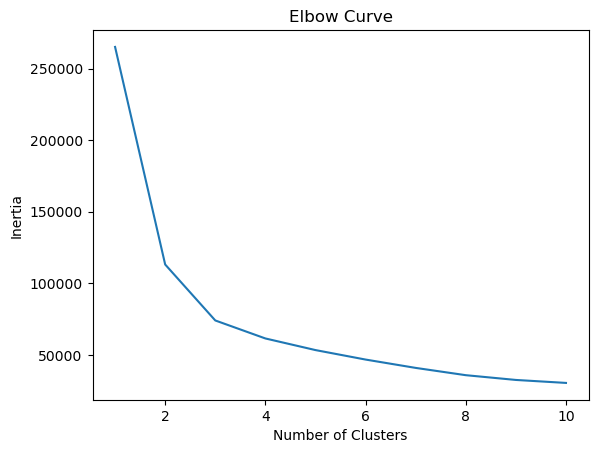

/home/samariddin/miniconda3/envs/py310/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [17]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Determine the number of clusters
elbow = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, random_state=0).fit(encoded_features)
    elbow.append(kmeans.inertia_)

# Plot elbow curve to determine the optimal number of clusters
plt.plot(range(1, 11), elbow)
plt.title('Elbow Curve')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.show()

# Perform clustering using K-means
kmeans = KMeans(n_clusters=3, random_state=0).fit(encoded_features)
user_labels = kmeans.labels_


In [18]:
# Cluster users using encoded features
n_clusters=10
kmeans = KMeans(n_clusters=n_clusters, random_state=0, n_init=10).fit(encoded_features)
cluster_labels = kmeans.labels_

In [19]:
# Print cluster sizes
for i in range(n_clusters):
    print(f"Cluster {i}: {np.sum(cluster_labels == i)} users")

Cluster 0: 42 users
Cluster 1: 100 users
Cluster 2: 174 users
Cluster 3: 54 users
Cluster 4: 84 users
Cluster 5: 104 users
Cluster 6: 114 users
Cluster 7: 123 users
Cluster 8: 78 users
Cluster 9: 70 users


In [20]:
# Evaluate the clustering performance using a clustering metric
from sklearn.metrics import silhouette_score

silhouette = silhouette_score(encoded_features, cluster_labels)
print("Silhouette Score: {:.2f}".format(silhouette))

Silhouette Score: 0.36


# Get Top-n recommendation

In [21]:
# load the encoded features
X_encoded = pd.read_pickle(dataPath + "data/extracted_features/encoded_features.pkl")

In [22]:
X_encoded.shape

(943, 10)

In [23]:
# perform clustering using KMeans
kmeans = KMeans(n_clusters=n_clusters, random_state=0, n_init=10).fit(X_encoded)

In [24]:
# assume we want to get top-10 recommendations for user with UID 0
user_id = 0
recommendation_count = 10

In [25]:
# find the cluster assignment for the user
user_index = X_encoded.index.get_loc(user_id)
user_cluster = kmeans.labels_[user_index]

# get the indices of all users in the same cluster
cluster_indices = np.where(kmeans.labels_ == user_cluster)[0]

In [26]:
# load the ratings data
cluster_ratings = pd.read_csv(dataPath + "data/dataset/ml-100k/ua.base", delimiter='\t', names=['UID', 'MID', 'rate', 'timestamp'], usecols=[0, 1, 2])
cluster_ratings

,UID,MID,rate
0,1,1,5
1,1,2,3
2,1,3,4
3,1,4,3
4,1,5,3
...,...,...,...
90565,943,1047,2
90566,943,1074,4
90567,943,1188,3
90568,943,1228,3


In [27]:
# get the ratings of all movies by users in the same cluster
cluster_ratings = cluster_ratings.loc[cluster_ratings['UID'].isin(X_encoded.iloc[cluster_indices].index)][['MID', 'rate']]

In [28]:
# compute the average rating for each movie
avg_ratings = cluster_ratings.groupby(['MID']).mean()
avg_ratings

,rate
MID,
1,3.944444
2,3.437500
3,3.461538
4,3.565217
5,3.250000
...,...
1672,2.000000
1678,1.000000
1679,3.000000


In [29]:
# sort the movies by their average rating and get the top-10 recommendations
top_n_recommendations = avg_ratings.sort_values(by='rate', ascending=False).head(recommendation_count)
top_n_recommendations

,rate
MID,
361,5.0
1446,5.0
1069,5.0
936,5.0
1169,5.0
611,5.0
1381,5.0
634,5.0
1131,5.0


In [30]:
# load the u.item file
item_df = pd.read_csv(dataPath + 'data/dataset/ml-100k/u.item', sep='|', encoding='latin-1', header=None, usecols=[0,1], names=['MID', 'name'])


In [31]:
# Recommendations list
for mid in top_n_recommendations.index.values:
    movie_name = item_df.loc[item_df['MID'] == mid]['name'].values[0]
    print(movie_name)

Incognito (1997)
Bye Bye, Love (1995)
Amateur (1994)
Brassed Off (1996)
Fresh (1994)
Laura (1944)
Losing Chase (1996)
Microcosmos: Le peuple de l'herbe (1996)
Safe (1995)
Switchblade Sisters (1975)


In [32]:
# Movies user rated about 4-5
data = pd.read_csv(
    dataPath + "data/dataset/ml-100k/u1.base",
    sep="\t",
    header=None,
    names=["UID", "MID", "rate", "timestamp"],
)
data["UID"] = data["UID"].astype(int)
data["rate"] = data["rate"].astype(int)
data = data[data["rate"] > 4]
data = data[data["UID"] == user_id+1]
data = data.sort_values(by="rate", ascending=False)
data = data.drop_duplicates(subset=["MID"], keep="first")
data = data.drop(["UID", "rate", "timestamp"], axis=1)

In [33]:
for mid in data["MID"]:
    movie_name = item_df.loc[item_df["MID"] == mid]["name"].values[0]
    print(movie_name)

Toy Story (1995)
Amadeus (1984)
Jean de Florette (1986)
Manon of the Spring (Manon des sources) (1986)
Monty Python and the Holy Grail (1974)
Wrong Trousers, The (1993)
Empire Strikes Back, The (1980)
Princess Bride, The (1987)
Aliens (1986)
12 Angry Men (1957)
Return of the Jedi (1983)
Terminator, The (1984)
Dead Man Walking (1995)
Graduate, The (1967)
Nikita (La Femme Nikita) (1990)
Back to the Future (1985)
Cyrano de Bergerac (1990)
When Harry Met Sally... (1989)
Sling Blade (1996)
Chasing Amy (1997)
Chasing Amy (1997)
Full Monty, The (1997)
Sleeper (1973)
Big Night (1996)
Godfather, The (1972)
Lone Star (1996)
Mighty Aphrodite (1995)
Mr. Holland's Opus (1995)
French Twist (Gazon maudit) (1995)
Antonia's Line (1995)
Crumb (1994)
Clerks (1994)
Eat Drink Man Woman (1994)
Hoop Dreams (1994)
Star Wars (1977)
Professional, The (1994)
Priest (1994)
Three Colors: Red (1994)
Searching for Bobby Fischer (1993)
Blade Runner (1982)
Welcome to the Dollhouse (1995)
Mystery Science Theater 3000: 